# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print(brain_name)
print(brain)

TennisBrain
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Train the agent with DDPG

In [31]:
import importlib
import sys
importlib.reload(sys.modules['maddpg'])
importlib.reload(sys.modules['constants'])

from maddpg import Agent
from constants import *
from collections import deque
import numpy as np
from maddpg import store, get_actions
import matplotlib.pyplot as plt
import time

In [32]:
agent_0 = Agent(state_size, action_size, FC1_UNITS, FC2_UNITS, num_agents=1)
agent_1 = Agent(state_size, action_size, FC1_UNITS, FC2_UNITS, num_agents=1)

In [33]:
def train(n_episodes=2000, max_t=5000, train_mode=True):
    """Multi-Agent Deep Deterministic Policy Gradient (MADDPG)
    
    Params
    ======
        n_episodes (int)      : maximum number of training episodes
        max_t (int)           : maximum number of timesteps per episode
        train_mode (bool)     : if 'True' set environment to training mode

    """
    scores_deque = deque(maxlen=PRINT_EVERY)
    scores = []
    best_score = 0.0
    add_noise = True

    for i_episode in range(1, n_episodes+1):
        if i_episode > STOP_NOISE_AFTER_EP:
            add_noise = False
        env_info = env.reset(train_mode=train_mode)[brain_name]         # reset the environment
        states = np.reshape(env_info.vector_observations, (1,48)) # get states and combine them
        agent_0.reset()
        agent_1.reset()
        scores_ep = np.zeros(num_agents)
        for t in range(max_t):
            action_0 = agent_0.act(states, add_noise)    # agent 0 chooses an action
            action_1 = agent_1.act(states, add_noise)    # agent 1 chooses an action
            actions = np.concatenate((action_0, action_1), axis=0).flatten()           # choose agent actions and combine them
            env_info = env.step(actions)[brain_name]           # send both agents' actions together to the environment
            next_states = np.reshape(env_info.vector_observations, (1, 48)) # combine the agent next states
            rewards = env_info.rewards                         # get reward
            done = env_info.local_done                         # see if episode finished
            agent_0.step(t, states, actions, rewards[0], next_states, done, 0) # agent 1 learns
            agent_1.step(t, states, actions, rewards[1], next_states, done, 1) # agent 2 learns
            scores_ep += np.max(rewards)                          # update the score for each agent
            states = next_states                               # roll over states to next time step
            if np.any(done):                                   # exit loop if episode finished
                break

        max_score = np.max(scores_ep)
        scores_deque.append(max_score)
        scores.append(max_score)
        if max_score > best_score:
            best_score = max_score
        print('\rEpisode {}\tAverage Score: {:.2f} best_score {}'.format(i_episode, np.mean(scores_deque), best_score), end="")
 
        # print results
        if i_episode % PRINT_EVERY == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))

        # determine if environment is solved and keep best performing models
        if np.mean(scores_deque) >= SOLVED_SCORE:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            store(agent_0, agent_1)
            break
    return scores

In [34]:
# train the agent
start_time = time.time()
scores = train(n_episodes = 8000, max_t = 5000)
end_time = time.time()
total_time = end_time - start_time
print(f"\nTotal time took for training: {total_time/60} min.")

Episode 200	Average Score: 0.01 best_score 0.20000000298023224
Episode 400	Average Score: 0.02 best_score 0.60000000894069676
Episode 600	Average Score: 0.05 best_score 0.6000000089406967
Episode 800	Average Score: 0.06 best_score 0.6000000089406967
Episode 1000	Average Score: 0.10 best_score 0.7000000104308128
Episode 1200	Average Score: 0.27 best_score 2.2000000327825546
Episode 1271	Average Score: 0.50 best_score 5.2000000774860386
Environment solved in 1271 episodes!	Average Score: 0.50

Total time took for training: 8.693374188741048 min.


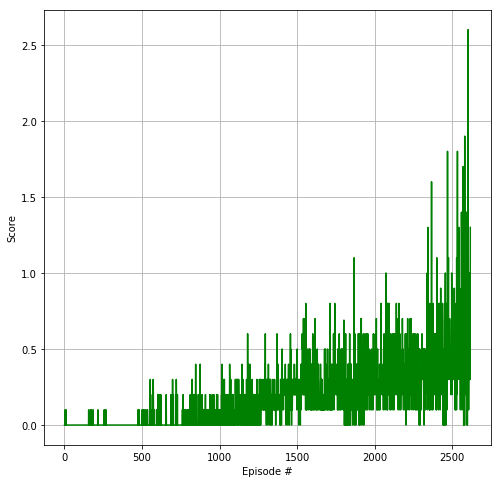

In [30]:
# plot the scores
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, c='g', label='MADDPG')
plt.grid(True)      
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
env.close()